In [1]:
import json
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy as np
import magneticfielddb as mag
import subprocess

In [2]:
# A generic input file for geometry_diag that works for all
inputfile={
    "grid":
    {   
        "type": "Cartesian2d",
        "n"  : 3,
        "Nx" : 80,
        "Ny" : 80,
        "Nz" : 20,
        "Npsi" : 32,
        "Neta" : 640,
        "scaleR": [1.2,1.2],
        "scaleZ": [2.4,2.4],
    },
    "boundary":
    {
        "wall": 
        {
            "type" : "heaviside",
            "boundary" : 1.1,
            "alpha" : 0.2
        },
        "sheath": 
        {
            "boundary" : 0.1,
            "alpha" : 0.01
        }
    },
    "magnetic_field" : 
    {
        "input" : "params"  
    }
}

In [3]:
# Display sorted contents of the data base
for f in sorted(mag.files()) :
    print(f)
    #print(mag.select(f))

./circular.json
./enrx_tcv.json
./enrx_torpex.json
./guenther.json
./toroidal.json
AUG/Iconst_Te_70eV_B0_2T.json
AUG/falchetto_Iconst_Te_150eV_B0_2T.json
COMPASS/Iconst.json
COMPASS/Iconst_woX.json
COMPASS/Iconst_woX_circ.json
COMPASS/compass_-1X.json
COMPASS/compass_-2X.json
COMPASS/compass_1X.json
COMPASS/compass_2X.json
COMPASS/woX_Taylor.json
COMPASS/woX_circ_Taylor.json
TJ-K/Iconst.json
TJ-K/Iconst_elong.json
TJ-K/Iconst_elong_d_e_AUG.json
TJ-K/Taylor.json
TJ-K/Taylor_circ.json
TJ-K/Taylor_elong.json
TJ-K/rfp_elong.json
TJ-K/woX_rfp_elong.json


 Since geometry_diag is fairly quick our idea is to store the input and output in temporary files
 that are overwritten in each simulation and removed at the end of the notebook

In [4]:
# Our first simulation

f = "COMPASS/compass_2X.json"
inputfile["magnetic_field"]["params"] = mag.select(f)
with open( "temp.json", 'w') as inp:
    inp.write( json.dumps( inputfile,
                          sort_keys=True, ensure_ascii=True))
try:
    print( f)
    subprocess.run( ["./geometry_diag.sh", "temp.json", "temp.nc" ],
              check=True, capture_output=True)
except subprocess.CalledProcessError as e:
    print(e.stderr)

COMPASS/compass_2X.json


In [5]:
# Define a plotting routine
def plot( f):
    ncin = Dataset( f, 'r', format="NETCDF4")
    pp = json.loads(ncin.inputfile)
    
    p = pp["magnetic_field"]["params"]
    equi = p["equilibrium"]
    desc = p["description"]
    
    x = ncin["x"][:]
    y = ncin["y"][:]
    xc = np.kron( np.ones(np.shape(y)),x).reshape( (np.size(y), np.size(x)))
    yc = np.kron( y, np.ones(np.shape(x))).reshape( (np.size(y), np.size(x)))


    frows = 1
    fcols = 2
    fig,ax=plt.subplots(frows,fcols,figsize=(fcols*5,frows*6),dpi= 80, facecolor='w', edgecolor='k')
    #im = ax[0][0].pcolormesh(xc,yc,ncin["Psip"][:,:], shading='gouraud', cmap='seismic' )

    #https://matplotlib.org/stable/tutorials/colors/colormaps.html
    im = ax[0].contourf(xc,yc,ncin["Psip"][:,:],cmap="twilight_r") 
#     im = ax[0].pcolormesh(xc,yc,ncin["Rho_p"][:,:],cmap="gist_ncar", shading ="gouraud")
    fig.colorbar(im, ax=ax[0])
    if desc != "none" :
        im = ax[0].contour( xc, yc, ncin["Psip"][:,:], levels=[0], linewidths=2,colors='k')

    ax[0].set_title( "Psi")
    ax[0].axis("scaled")
    ax[0].set_xlabel( "R [m]")
    ax[0].set_ylabel( "Z [m]")

    if( desc != "none" and desc != "centeredX" ):
        im = ax[1].plot(ncin["rho_p"][:3*28],np.abs(ncin["q-profile"][:3*28])) 
        ax[1].set_title( "q-profile")
        ax[1].set_xlim([0,1])
        ax[1].set_xlabel( r"$\rho_p$")
                                                  
    print(equi, desc)
    if ( equi == "solovev" or equi == "polynomial") :
        print( "triangularity=%.1f" % p["triangularity"]+\
            " elongation=%.1f"%p["elongation"])
    else:
        print( "triangularity=0 elongation=1" )
    #plt.savefig( "tcv")
    plt.show()
    ncin.close()

solovev doubleX
triangularity=0.3 elongation=1.4


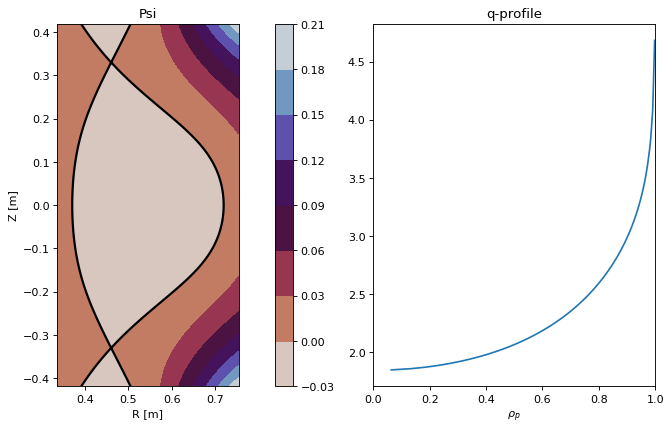

In [6]:
# plot our first simulation and fine-tune the plotting routine
plot( "temp.nc")

./circular.json
circular standardO
triangularity=0 elongation=1


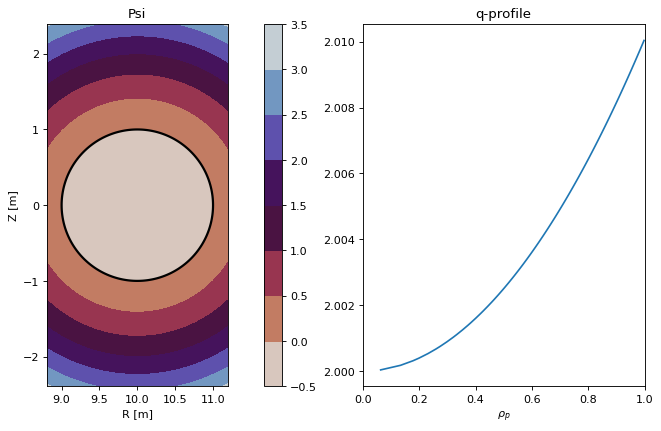

./enrx_tcv.json
least squares fit; Matlab geometry file of TCV equilibrium for Enabling research project: X-point
polynomial standardX
triangularity=0.4 elongation=1.5


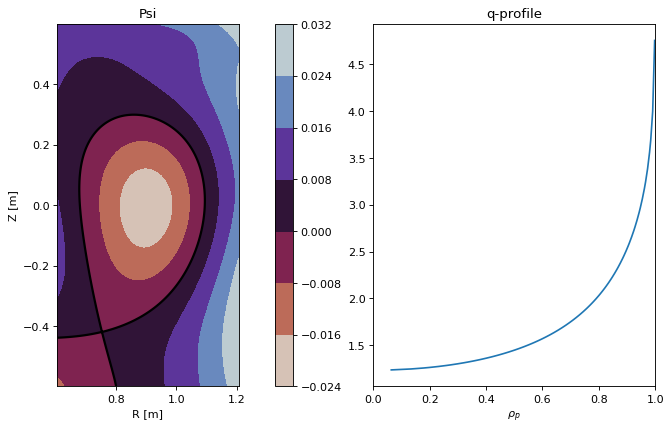

./enrx_torpex.json
least squares fit; Matlab geometry file of Torpex equilibrium for Enabling research project: X-point
solovev centeredX
triangularity=0.0 elongation=1.0


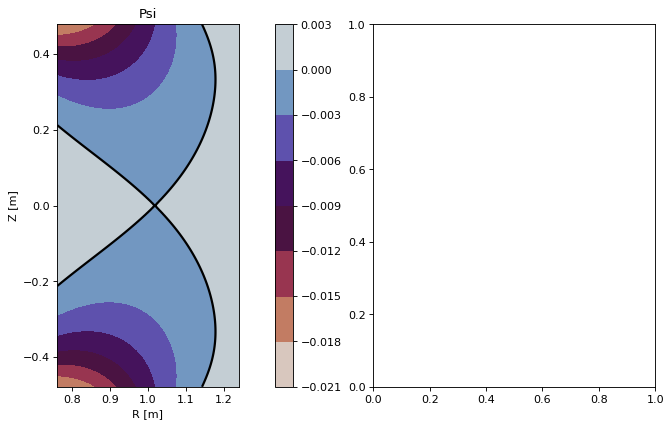

./guenther.json
Sine functions; Günter et at, J. Comput. Phys. 209 (2005) 354
guenther square
triangularity=0 elongation=1


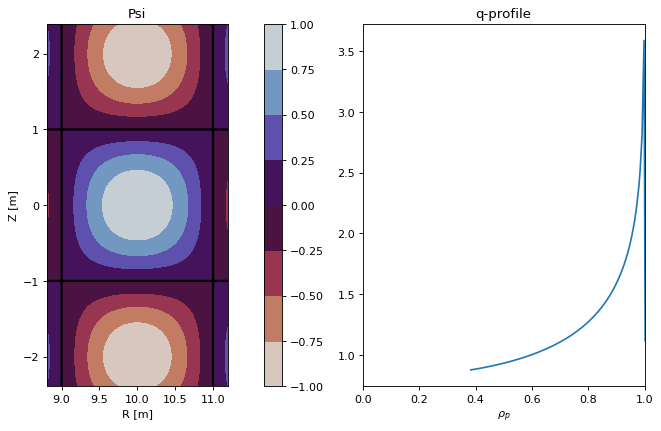

./toroidal.json
toroidal none
triangularity=0 elongation=1


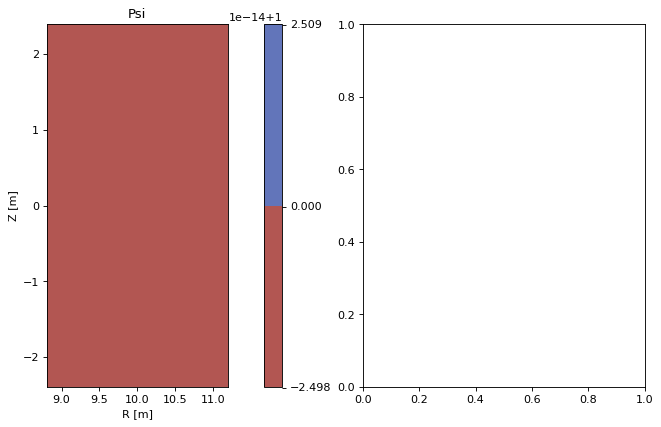

AUG/Iconst_Te_70eV_B0_2T.json
solovev standardX
triangularity=0.3 elongation=1.7


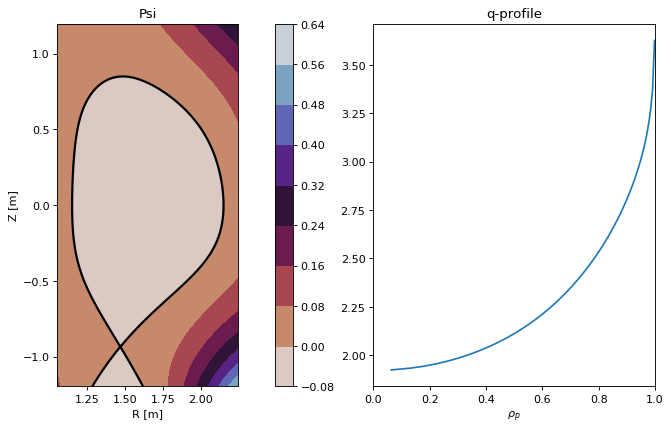

AUG/falchetto_Iconst_Te_150eV_B0_2T.json
solovev standardO
triangularity=0.3 elongation=1.7


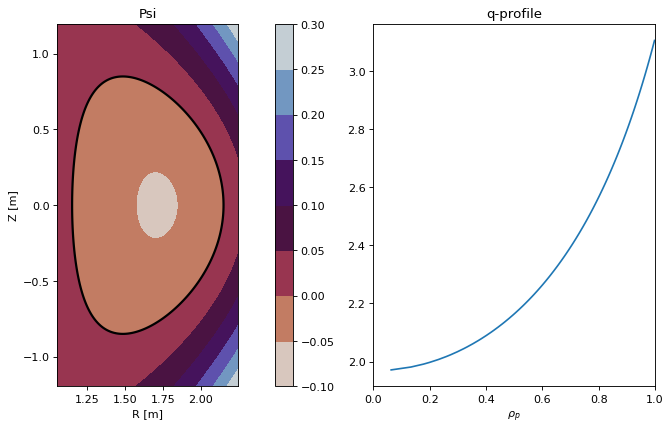

COMPASS/Iconst.json
Mathematica; geometry_params_Xpoint.json in Feltor
solovev standardX
triangularity=0.5 elongation=1.8


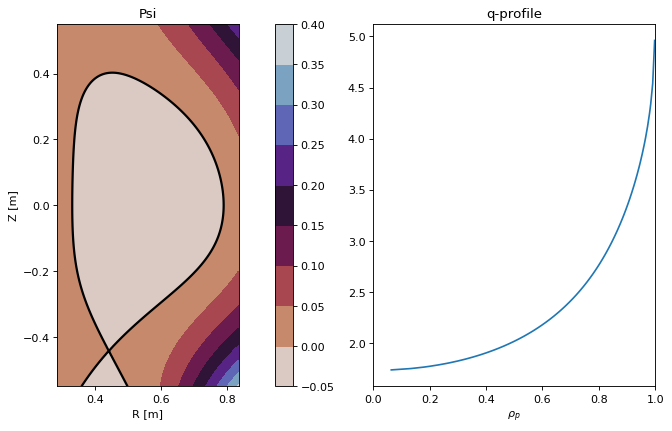

COMPASS/Iconst_woX.json
solovev standardO
triangularity=0.5 elongation=1.8


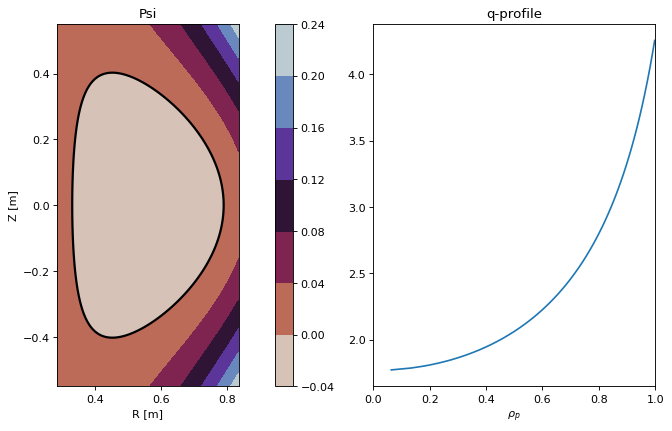

COMPASS/Iconst_woX_circ.json
solovev standardO
triangularity=0.0 elongation=1.0


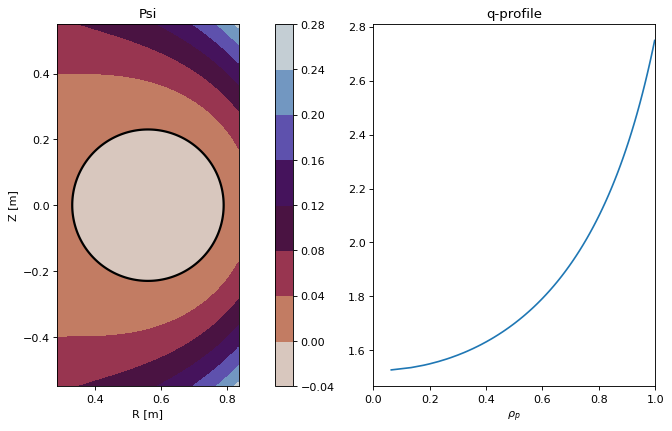

COMPASS/compass_-1X.json
solovev standardX
triangularity=-0.3 elongation=1.4


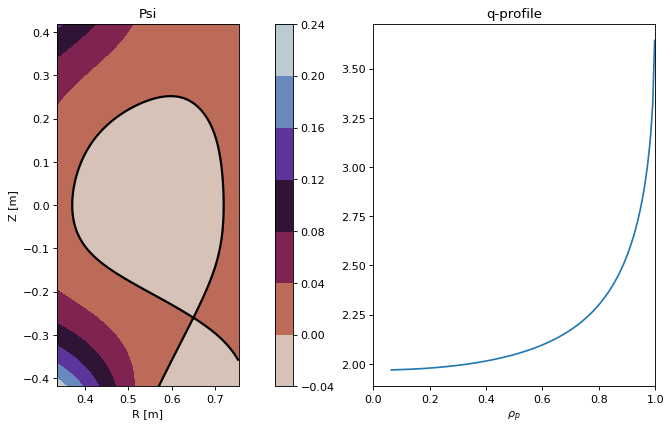

COMPASS/compass_-2X.json
solovev doubleX
triangularity=-0.3 elongation=1.4


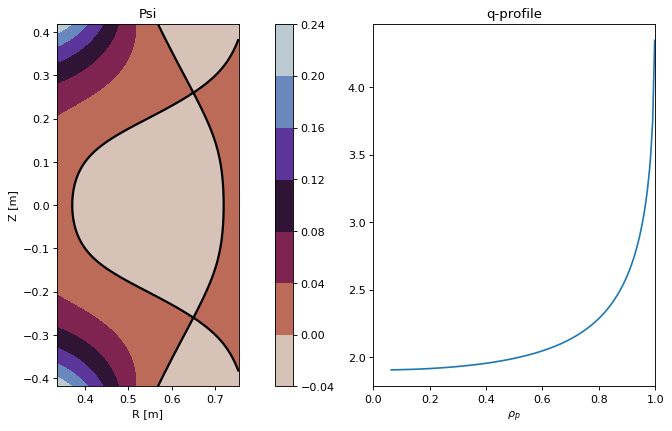

COMPASS/compass_1X.json
Mathematica; eye fit of Fig. 3 in R Panek et al 2015 Plasma Phys. Control. Fusion 58 014015
solovev standardX
triangularity=0.3 elongation=1.4


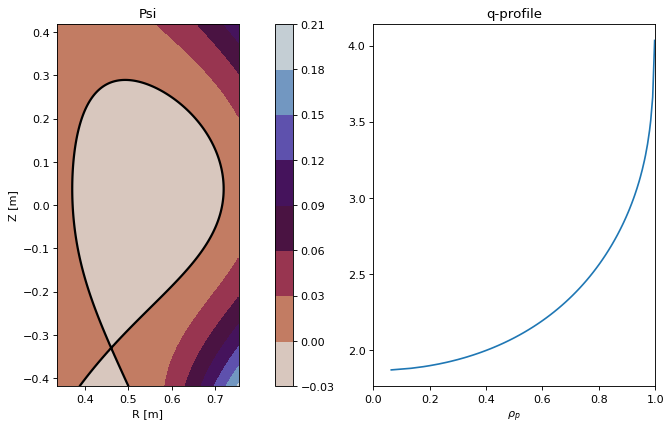

COMPASS/compass_2X.json
solovev doubleX
triangularity=0.3 elongation=1.4


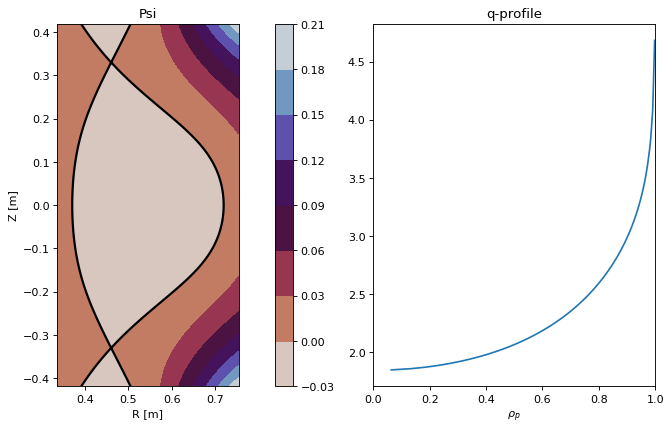

COMPASS/woX_Taylor.json
solovev standardO
triangularity=0.5 elongation=1.8


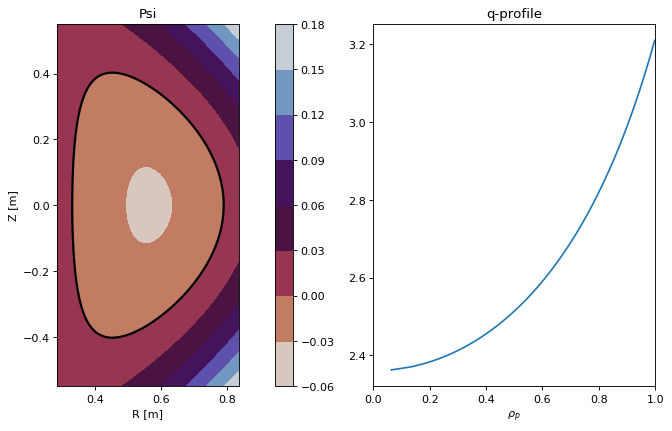

COMPASS/woX_circ_Taylor.json
Mathematica; used in Wiesenberger 2014, PhD thesis; geometry_params.json in Feltor
solovev standardO
triangularity=0.0 elongation=1.0


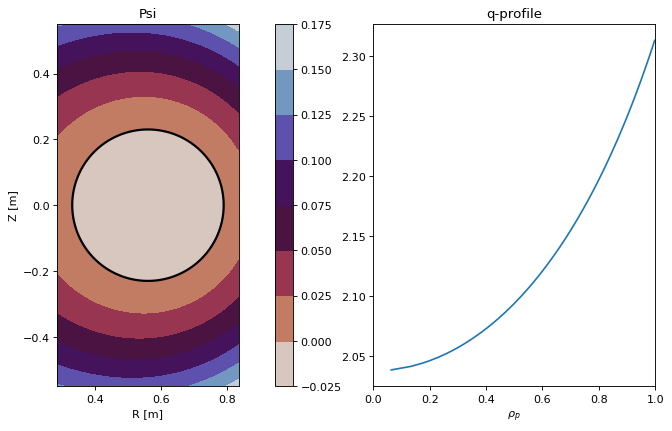

TJ-K/Iconst.json
solovev standardX
triangularity=0.0 elongation=1.0


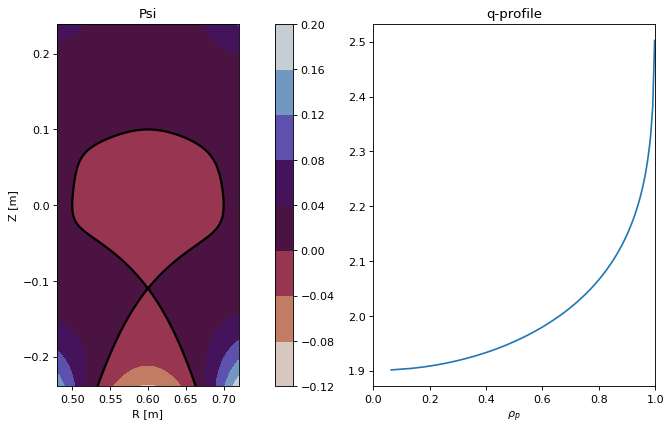

TJ-K/Iconst_elong.json
Mathematica; used in Wiesenberger 2014, PhD thesis
solovev standardX
triangularity=0.5 elongation=1.8


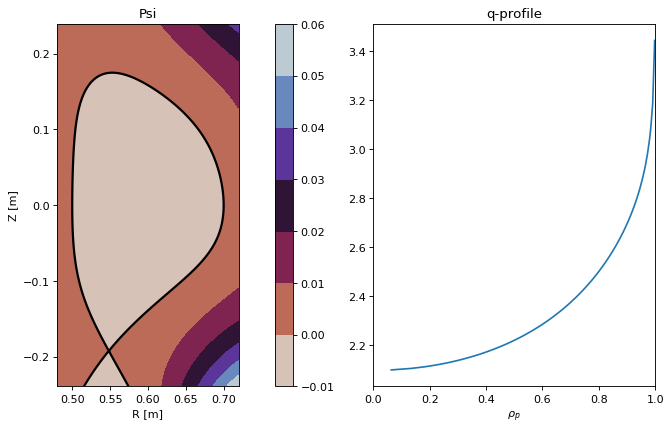

TJ-K/Iconst_elong_d_e_AUG.json
solovev standardX
triangularity=0.3 elongation=1.7


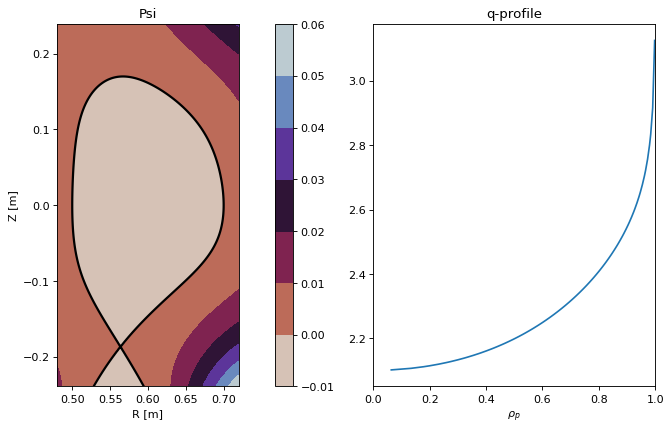

TJ-K/Taylor.json
solovev standardX
triangularity=0.0 elongation=1.0


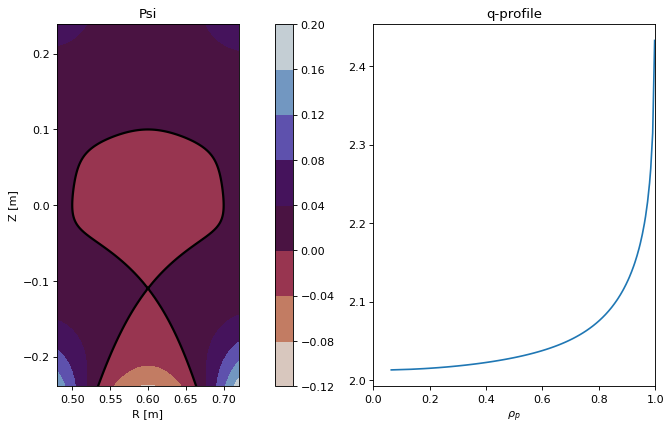

TJ-K/Taylor_circ.json
solovev standardO
triangularity=0.0 elongation=1.0


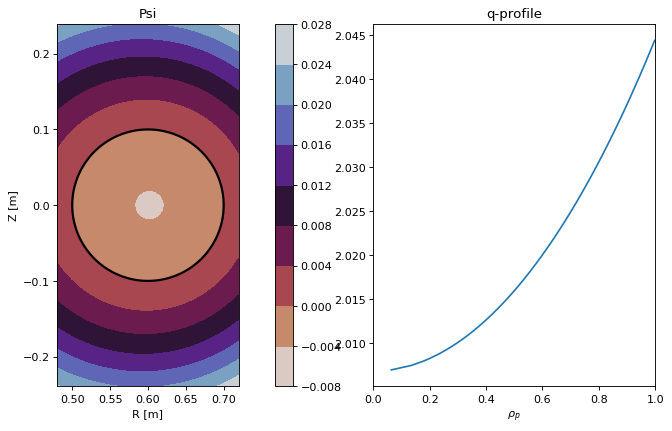

TJ-K/Taylor_elong.json
solovev standardX
triangularity=0.5 elongation=1.8


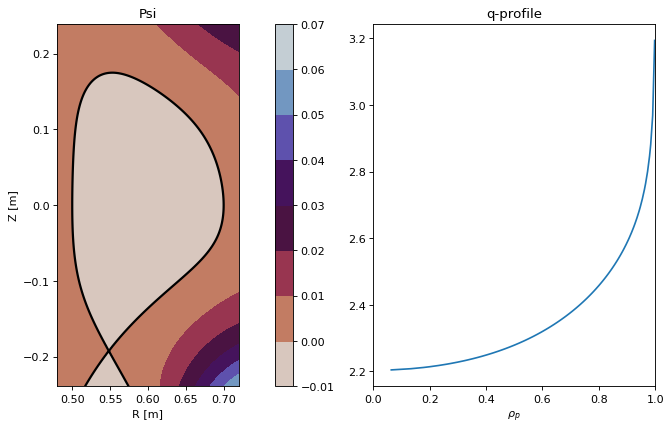

TJ-K/rfp_elong.json
solovev standardX
triangularity=0.5 elongation=1.8


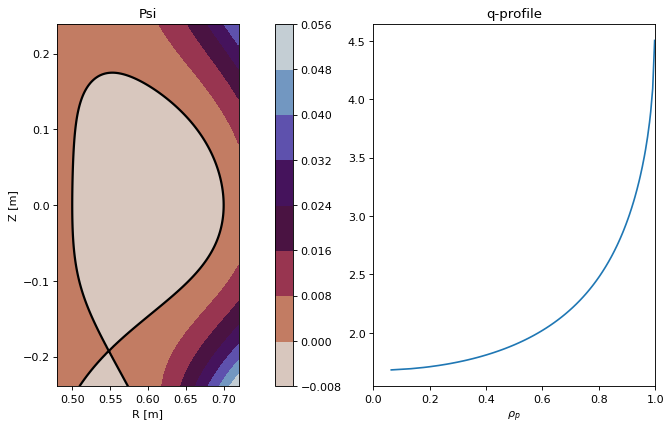

TJ-K/woX_rfp_elong.json
solovev standardO
triangularity=0.5 elongation=1.8


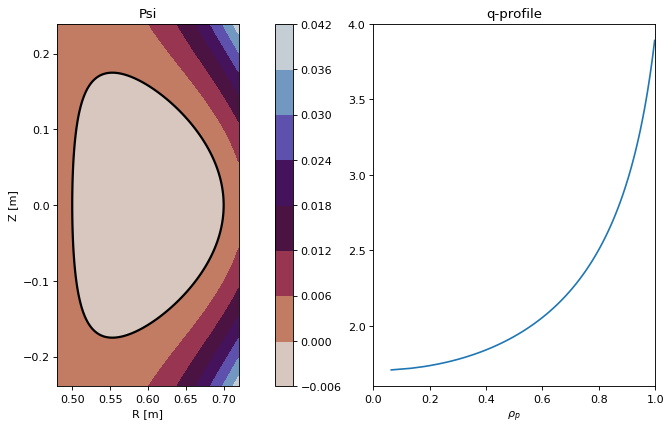

In [7]:
# Now do the same for all geometry files
for f in sorted(mag.files()) :
    subprocess.run ( ["rm", "-f", "temp.nc"])
    inputfile["magnetic_field"]["params"] = mag.select(f)
    with open( "temp.json", 'w') as inp:
        inp.write( json.dumps( inputfile,
                              sort_keys=True, ensure_ascii=True))
    try:
        print( f)
        if( "comment" in inputfile["magnetic_field"]["params"]):
            print( inputfile["magnetic_field"]["params"]["comment"])
        subprocess.run( ["./geometry_diag.sh", "temp.json", "temp.nc" ],
                  check=True, capture_output=True)
    except subprocess.CalledProcessError as e:
        print(e.stderr)
    plot("temp.nc")

In [8]:
# clean up
subprocess.run ( ["rm", "-f", "temp.nc"])
subprocess.run ( ["rm", "-f", "temp.json"])

CompletedProcess(args=['rm', '-f', 'temp.json'], returncode=0)